# Severity of storms 

### 1.1 Business problem


Our project will focus on analyzing and predicting the severity of tornadoes across various regions in America in terms of property damage. To analyze this, we will take the last 10 years of tornado data to represent an approximate measure of it. To calculate this, we will establish a threshold for measuring the severity using the amount of property damage caused by tornadoes. We will predict the property damage of tornadoes and use a scale of low, medium, and high to represent the severity.  
In addition, we will also compare attitudes across each of the 4 seasons - summer, spring, winter, fall, and see if there are any trends present across the 10 year span that shows when tornadoes are most common and damaging. The trends will help us be more accurate in predicting the property damage caused by the tornadoes  per region during different seasons/times of the year.


### 1.2 Datasets


Our dataset details instances of severe weather across a 15 year period. We will be looking at Tornados across this time period. We are given the locations that the Tornados are in, the category of Tornadoes, fatalities, property damage, and the length of the storm. From this we created a target feature called severity which assigns tornados a number from 1 to 10 based on how severe they are.


### 1.3 Proposed analytics solution

 How we get to the target variable -- severity index
The severity index will be calculated by taking into account the property damage, the lives lost in the event, 


In [29]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read all data into one single dataframe
df_all_data = pd.read_csv('./dataset/storm_event_details_2010.csv')


for i in range(2011,2021):
    df_temp = pd.read_csv(f'./dataset/storm_event_details_{i}.csv')
    df_all_data = df_all_data.append(df_temp, ignore_index=True)



/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/3914789818.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_data = df_all_data.append(df_temp, ignore_index=True)
/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/3914789818.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_data = df_all_data.append(df_temp, ignore_index=True)
/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/3914789818.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_data = df_all_data.append(df_temp, ignore_index=True)
/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/3914789818.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pa

In [30]:
## Remove unused columns and format continuous columns

df_hur = df_all_data[df_all_data['EVENT_TYPE']=='Tornado']
df_hur = df_hur.drop(columns=['TOR_OTHER_WFO', 'END_YEARMONTH', 'EVENT_TYPE', 'END_DATE_TIME',
                                           'TOR_OTHER_CZ_STATE','TOR_OTHER_CZ_FIPS','TOR_OTHER_CZ_NAME','DATA_SOURCE','EPISODE_NARRATIVE',
                                            'EVENT_NARRATIVE','WFO','SOURCE','CZ_TIMEZONE','BEGIN_AZIMUTH','END_AZIMUTH','BEGIN_LAT',
                                            'END_LAT','BEGIN_LON','END_LON','STATE_FIPS','BEGIN_RANGE','END_RANGE','DAMAGE_CROPS',
                                            'BEGIN_TIME','END_TIME','BEGIN_LOCATION','END_LOCATION','FLOOD_CAUSE','MAGNITUDE_TYPE',
                                            'MAGNITUDE','CZ_FIPS','CZ_TYPE','CZ_NAME','CATEGORY'])
cols = ['INJURIES_INDIRECT', 'INJURIES_DIRECT', 'DEATHS_INDIRECT', 'DEATHS_DIRECT']
df_hur = df_hur.assign(HARM_TOTAL=df_hur[cols].sum(1)).drop(cols,1)
df_hur['TOR_AREA'] = df_hur['TOR_LENGTH']*df_hur['TOR_WIDTH']
df_hur = df_hur.drop(columns=['TOR_LENGTH', 'TOR_WIDTH'])
df_hur = df_hur.dropna()


/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/2115226861.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_hur = df_hur.assign(HARM_TOTAL=df_hur[cols].sum(1)).drop(cols,1)


In [31]:
## Format DAMAGE_PROPERTY column to be float instead of object

dmg = pd.DataFrame(df_hur['DAMAGE_PROPERTY'])

print(dmg)
for index, row in dmg.iterrows():
    val = row['DAMAGE_PROPERTY']
    if val[-1:] == 'B':
        row['DAMAGE_PROPERTY'] = float(val[:-1])*1000000
        # print(float(row['DAMAGE_PROPERTY'][:-1])*1000000)
    elif val[-1:] == 'M':
        row['DAMAGE_PROPERTY'] = float(val[:-1])*1000
        # print(float(row['DAMAGE_PROPERTY'][:-1])*1000)
    elif val[-1:] == 'K':
        row['DAMAGE_PROPERTY'] = float(val[:-1])*1
        # print(float(row['DAMAGE_PROPERTY'][:-1]))

df_hur['DAMAGE_PROPERTY'] = dmg

       DAMAGE_PROPERTY
75               5.00K
304              1.50M
617             10.00K
731            750.00K
732             10.00K
...                ...
688471           0.00K
688472         250.00K
688495          60.00K
688497           0.00K
688560           0.00K

[12945 rows x 1 columns]


In [32]:
## Sort by priority variable and find data split percentages

df_hur = df_hur.sort_values('DAMAGE_PROPERTY', ascending=False)
df_hur.info()
df_hur = df_hur.loc[df_hur['TOR_F_SCALE']!='EFU']
print(df_hur['TOR_F_SCALE'].value_counts()/len(df_hur) * 100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12945 entries, 100619 to 688560
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BEGIN_YEARMONTH  12945 non-null  int64  
 1   BEGIN_DAY        12945 non-null  int64  
 2   END_DAY          12945 non-null  int64  
 3   EPISODE_ID       12945 non-null  int64  
 4   EVENT_ID         12945 non-null  int64  
 5   STATE            12945 non-null  object 
 6   YEAR             12945 non-null  int64  
 7   MONTH_NAME       12945 non-null  object 
 8   BEGIN_DATE_TIME  12945 non-null  object 
 9   DAMAGE_PROPERTY  12945 non-null  object 
 10  TOR_F_SCALE      12945 non-null  object 
 11  HARM_TOTAL       12945 non-null  int64  
 12  TOR_AREA         12945 non-null  float64
dtypes: float64(1), int64(7), object(5)
memory usage: 1.4+ MB
EF0    51.117296
EF1    35.737575
EF2     9.852883
EF3     2.576541
EF4     0.628231
EF5     0.087475
Name: TOR_F_SCALE, dtype: float

In [33]:
df_hur['MONTH_NAME'].value_counts()/len(df_hur) * 100

April        21.677932
May          20.548708
June         12.413519
July          7.093439
March         6.727634
August        6.067594
October       5.137177
November      4.580517
January       4.413519
February      4.159046
September     3.618290
December      3.562624
Name: MONTH_NAME, dtype: float64

In [34]:
## Split data into strata and sample proportinally (stratified sampling)

sampled_df = df_hur.groupby('TOR_F_SCALE', group_keys=False).apply(lambda x: x.sample(frac=0.1))
sampled_df
# sampled_df['MONTH_NAME'].value_counts()/len(df_hur) * 100

,BEGIN_YEARMONTH,BEGIN_DAY,END_DAY,EPISODE_ID,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,DAMAGE_PROPERTY,TOR_F_SCALE,HARM_TOTAL,TOR_AREA
554280,201810,29,29,131963,789514,OREGON,2018,October,29-OCT-18 14:30:00,0.2,EF0,0,1.0
575624,201903,14,14,135813,815060,ALABAMA,2019,March,14-MAR-19 18:39:00,0.0,EF0,0,2142.0
663801,202004,8,8,145944,877156,INDIANA,2020,April,08-APR-20 21:13:00,50.0,EF0,0,2578.5
10595,201005,20,20,40121,233351,MISSOURI,2010,May,20-MAY-10 16:45:00,0.0,EF0,0,4.0
577525,201904,30,30,136054,818093,MISSOURI,2019,April,30-APR-19 21:02:00,0.0,EF0,0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210689,201305,18,18,75824,457695,KANSAS,2013,May,18-MAY-13 18:18:00,140.0,EF4,0,7700.0
140763,201104,27,27,50516,301943,ALABAMA,2011,April,27-APR-11 13:40:00,0.0,EF4,1,22660.0
95457,201104,22,22,52847,317910,MISSOURI,2011,April,22-APR-11 18:59:00,250000.0,EF4,5,13543.2
599455,201905,27,27,136052,816403,OHIO,2019,May,27-MAY-19 21:41:00,500000.0,EF4,167,19078.5


In [35]:
cont_features = []
for (columnName, columnData) in sampled_df.iteritems():
    if type(columnData) == int or float:
        cont_features.append(columnName)
        
print(cont_features)

['BEGIN_YEARMONTH', 'BEGIN_DAY', 'END_DAY', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'YEAR', 'MONTH_NAME', 'BEGIN_DATE_TIME', 'DAMAGE_PROPERTY', 'TOR_F_SCALE', 'HARM_TOTAL', 'TOR_AREA']


/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/489640541.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in sampled_df.iteritems():


from sklearn import preprocessing
scaled_df = preprocessing.MinMaxScaler().fit_transform(df2)
sdf=pd.DataFrame(scaled_df, columns=df2.columns)
#sdf['price_range']=cl_df['prie_range']
sdf.head()

/var/folders/b1/t1n97j495rq26g0zhqy_3ty80000gn/T/ipykernel_85206/3205490076.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=sampled_df, x='DAMAGE_PROPERTY', y='HARM_TOTAL', palette='deep')


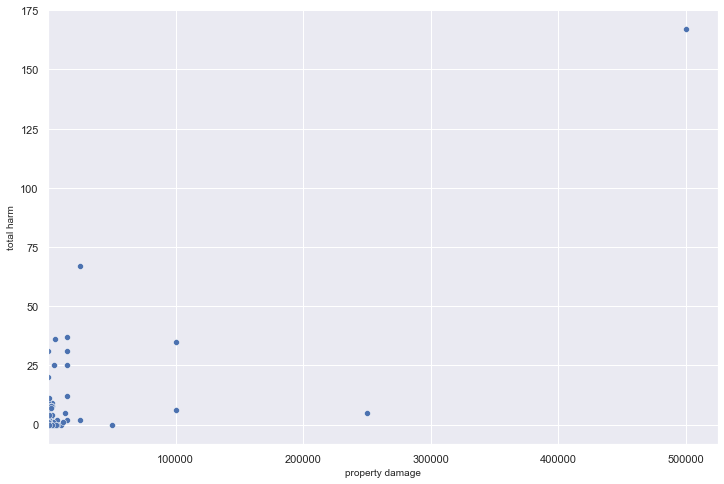

In [36]:
# visualize damage property scale of tornado with a scattarplot and 
#tor_f_scale 

#df_hur.dropna()
#df_hur = df_hur.astype({'DAMAGE_PROPERTY':'float'})

#df_hur['logarithm_base10'] = np.log10(df_hur['DAMAGE_PROPERTY'])
#df_hur['natural_log'] = np.log(df_hur['DAMAGE_PROPERTY'])
#plt.scatter(df_hur.DAMAGE_PROPERTY, df_hur.HARM_TOTAL, linewidths = 2, edgecolor ="green", s = 1, hue = 'TOR_F_SCALE')


sns.set(rc={'figure.figsize':(12, 8)})
sns.scatterplot(data=sampled_df, x='DAMAGE_PROPERTY', y='HARM_TOTAL', palette='deep')
#robust scaling 


plt.xlabel('property damage', fontsize=10)
plt.ylabel('total harm', fontsize=10)
plt.xlim(0.1)
plt.show()


#correlation = sampled_df.corr()
#print(correlation.loc['DAMAGE_PROPERTY', 'HARM_TOTAL'])


#visualize tornado area 

In [37]:
ndf = sampled_df[['HARM_TOTAL', 'TOR_AREA']].copy()
ndf

,HARM_TOTAL,TOR_AREA
554280,0,1.0
575624,0,2142.0
663801,0,2578.5
10595,0,4.0
577525,0,20.0
...,...,...
210689,0,7700.0
140763,1,22660.0
95457,5,13543.2
599455,167,19078.5


In [38]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth = 2, criterion='entropy', random_state = 0)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(ndf, sampled_df['DAMAGE_PROPERTY'],  
                                                    test_size=0.33, random_state=0)


Y_train=Y_train.astype('int')
Y_test=Y_test.astype('int')

In [40]:
dt_clf.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)

In [41]:
y_pred = dt_clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, y_pred)
accuracy

0.3614457831325301

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)

cm_df = pd.DataFrame(cm)
cm_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,150,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
